Task Website: https://sites.google.com/view/simpletext-sota/home
Competition: https://codalab.lisn.upsaclay.fr/competitions/16616

Dataset: https://github.com/jd-coderepos/sota/tree/master



In [1]:
NOT_FOUND = "unanswerable\n"
TRAIN_PATH = "./data/train"

In [2]:

import os
import json

TRAIN_PATH = "./data/train"


def path_join(*args):
    return os.path.join(*args).replace('\\', '/') 

def find(extension, *args):
    p = path_join(*args)
    res = list(filter(lambda x: x.endswith(extension), os.listdir(p)))
    if res:
        return path_join(p, res[0])
    else:
        return None

all_paths = [(p, find("tex", TRAIN_PATH, p), find("json", TRAIN_PATH, p)) for p in os.listdir(TRAIN_PATH)]

def read(i):
    # print(i)
    tex = None
    jsn = None
    try:
        i, tex_path, jsn_path = all_paths[i]
    except Exception as ex:
        print(i)
        raise ex
    tex, jsn = None, None

    try:
        with open(tex_path) as f:
            tex = f.read()
    except: # tex not read
        pass
    
    if jsn_path:
        with open(jsn_path, encoding="utf-8") as f:
            jsn = f.read()
            try:
                jsn = eval(jsn)
            except:
                pass #"unanswerable" is not a dict, no eval possible/necessary
    
    return i, tex, jsn

In [3]:
import pandas as pd

n = len(all_paths)
data = []
for i, t, j in [read(i) for i in range(n)]:
    # if j and j != 'unanswerable\n':
    data.append((i, t, j))



In [4]:
df_raw = pd.DataFrame(data)
df_raw = df_raw.rename({0: "id", 1: "tex", 2: "jsn"}, axis=1)
df_raw

,id,tex,jsn
0,0704.1707,\documentclass{llncs}\n\usepackage{url}\n\usep...,unanswerable\n
1,0704.2295,\documentclass{llncs}\n\usepackage{graphicx}\n...,unanswerable\n
2,0704.3238,\documentclass{article} \n\RequirePackage{amsf...,unanswerable\n
3,0705.0599,\n\documentclass[a4paper]{article}\n\n\n\usepa...,unanswerable\n
4,0705.0742,"\documentclass[pre,12pt,aps]{revtex4}\n\usepac...",unanswerable\n
...,...,...,...
12283,2312.02139v1,\section{Results}\n\label{sec:results}\n\n\sub...,"[{'LEADERBOARD': {'Task': 'Image Generation', ..."
12284,2312.02185v1,\documentclass[conference]{IEEEtran}\n\IEEEove...,[{'LEADERBOARD': {'Task': 'Human Activity Reco...
12285,2312.03288v1,\documentclass{bmvc2k}\n\usepackage{times}\n\u...,[{'LEADERBOARD': {'Task': 'Skeleton Based Acti...
12286,2312.03430v1,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",[{'LEADERBOARD': {'Task': 'Semantic Segmentati...


In [5]:
# is "id" unique?

total_ids = len(df_raw["id"])
nonduplicate_ids = len(df_raw["id"].drop_duplicates())
print(total_ids)
print(nonduplicate_ids)
# -> yes

12288
12288


In [6]:
# how long are the tex?

df_raw["tex_len"] = df_raw["tex"].str.len()

In [8]:
# longest doc
df_raw.loc[df_raw["tex_len"].idxmax()]

id                                              2210.05974v3
tex        \documentclass{article}\n\usepackage[utf8]{inp...
jsn        [{'LEADERBOARD': {'Task': 'Click-Through Rate ...
tex_len                                            4539917.0
Name: 10978, dtype: object

In [15]:
# top 10 longest docs
df_t10 = df_raw.loc[df_raw["tex_len"].nlargest(10).index]

df_t10["pgfpicture"] = df_t10["tex"].str.contains("pgfpicture")

df_t10

,id,tex,jsn,tex_len,pgfigure
10978,2210.05974v3,\documentclass{article}\n\usepackage[utf8]{inp...,[{'LEADERBOARD': {'Task': 'Click-Through Rate ...,4539917.0,True
6121,1906.12269v1,\documentclass[sigconf]{acmart}\n\usepackage{x...,[{'LEADERBOARD': {'Task': 'Node Classification...,2454516.0,True
6546,1911.05485v6,\documentclass{article}\n\n\PassOptionsToPacka...,[{'LEADERBOARD': {'Task': 'Node Classification...,2018666.0,True
6545,1911.05485v5,\documentclass{article}\n\n\PassOptionsToPacka...,unanswerable\n,2018658.0,True
3629,1510.06516,"\documentclass[letterpaper,10pt,conference,two...",unanswerable\n,885157.0,True
12219,2310.16248v2,\pdfoutput=1\n\n\documentclass[11pt]{article}\...,[{'LEADERBOARD': {'Task': 'Language Identifica...,839296.0,False
2525,1406.6281,"\n\documentclass[journal,transmag]{IEEEtran}\n...",unanswerable\n,828243.0,False
4997,1803.06815v3,\n\n\documentclass[runningheads]{llncs}\n\usep...,[{'LEADERBOARD': {'Task': 'Semantic Segmentati...,736871.0,False
6603,1911.10927v1,"\documentclass[10pt,twocolumn,letterpaper]{art...",[{'LEADERBOARD': {'Task': 'Video Super-Resolut...,716000.0,False
5396,1810.05997v6,\documentclass{article} \usepackage{iclr2019_c...,[{'LEADERBOARD': {'Task': 'Node Classification...,674780.0,True


In [20]:
print(df_t10.loc[12219]["tex"])

\pdfoutput=1

\documentclass[11pt]{article}

\usepackage{acl}

\usepackage{times}
\usepackage{latexsym}
\usepackage[T1]{fontenc}
\usepackage[utf8]{inputenc}
\usepackage{microtype}
\usepackage[ruled,vlined]{algorithm2e}
\usepackage{enumitem}
\usepackage[para]{threeparttable}
\usepackage{booktabs}
\usepackage{multirow}
\usepackage{graphicx}
\usepackage{amsmath}
\usepackage{amssymb}
\usepackage{bm}



\makeatletter
\newcommand\footnoteref[1]{\protected@xdef\@thefnmark{\ref{#1}}\@footnotemark}
\makeatother


\newcommand{\basequ}{SET?\xspace}
\newcommand{\baseex}{SET!\xspace}
\newcommand{\eg}{e.g.,\xspace}
\newcommand{\ie}{i.e.,\xspace}

\def\argmax{\mbox{argmax}}
\def\dnrm#1{\mbox{}}
\def\numberlanguagesaccurate{1665\xspace}
\def\numberlanguagestotal{1832\xspace}
\def\numberlanguagediff{167\xspace}
\def\numlangslidcommunity{300\xspace}
\def\modelname{\mbox{GlotLID-M}\xspace}
\def\corpusname{\mbox{GlotLID-C}\xspace}
\def\genericname{\mbox{GlotLID}\xspace}
\def\macrolanguage{macrolanguage\xs

In [ ]:
df_raw["tex_len"].mean()

47539.96092315762

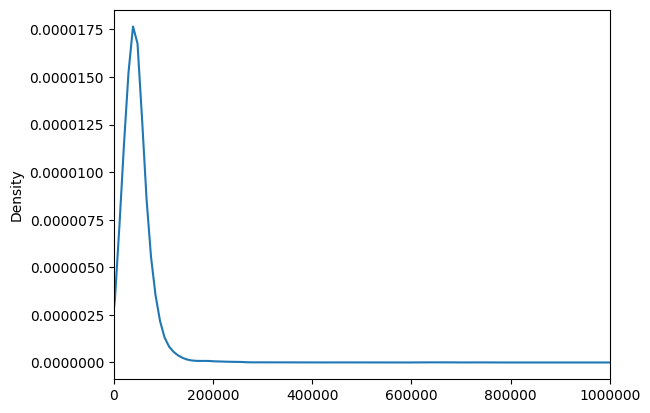

In [36]:
ax = df_raw["tex_len"].plot(kind="kde")
ax.set_xlim(0, 1000000)
# ax.set_yscale("linear")
# ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')

# How many are Null / Unanswerable?

In [7]:
df = df_raw
NOT_FOUND = "unanswerable\n"

df["isUnanswerable"] = df["jsn"] == NOT_FOUND
df["isNone"] = df["jsn"].isnull()

print(f"total len: {len(df)}")
print(f"None: {len(df[df['isNone']])}")
print(f"Unanswerable: {len(df[df['isUnanswerable']])}")
print(f"Does not start with [: {len(df[~df['jsn'].astype(str).str.startswith("[")])}")



total len: 12288
None: 0
Unanswerable: 4352
Does not start with [: 4352


# Leaderboard details

In [8]:
df["numLeaderboards"] = df["jsn"].apply(lambda c: len(c) if c and c != NOT_FOUND else 0)
df["hasLeaderboards"] = df["numLeaderboards"] > 0

print(f"= 0: {len(df[df['numLeaderboards'] == 0])}")
print(f"> 0: {len(df[df['numLeaderboards'] > 0])}")
print(f"> 5: {len(df[df['numLeaderboards'] > 5])}")
print(f"> 10: {len(df[df['numLeaderboards'] > 10])}")
print(f"> 40: {len(df[df['numLeaderboards'] > 40])}")
print(f"> 100: {len(df[df['numLeaderboards'] > 100])}")
print(f"> 200: {len(df[df['numLeaderboards'] > 200])}")

df_lt40 = df[df["numLeaderboards"] < 40]

= 0: 4352
> 0: 7936
> 5: 2912
> 10: 1297
> 40: 122
> 100: 17
> 200: 1


In [9]:
# pct_hasLeaderboard =  len(df[df["hasLeaderboards"] == False]) / len(df[df["hasLeaderboards"] == True])
pct_hasLeaderboard =  len(df[df["hasLeaderboards"]]) / len(df)
pct_hasLeaderboard

0.6458333333333334

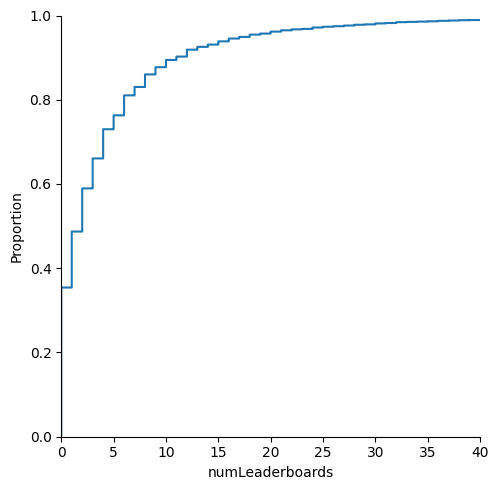

In [10]:
import seaborn as sns

ax = sns.displot(df["numLeaderboards"], kind="ecdf")
ax.set(xlim=(0, 40))

[(0.0, 40.0)]

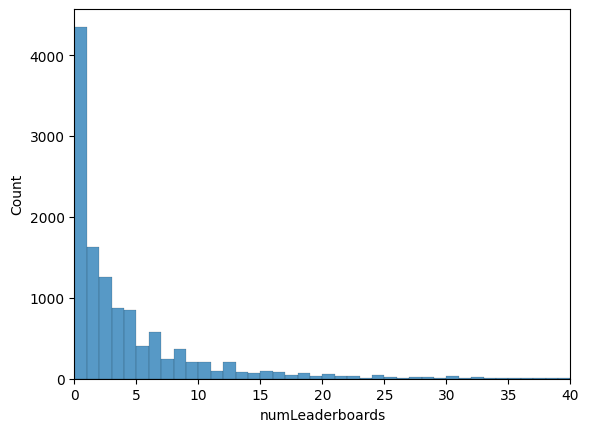

In [11]:
ax = sns.histplot(df["numLeaderboards"], bins=max(df["numLeaderboards"]))
ax.set(xlim=(0, 40))

In [12]:
df.loc[df["numLeaderboards"].idxmax()]

id                                                      2210.07606v1
tex                                                             None
jsn                [{'LEADERBOARD': {'Task': 'Node Classification...
isUnanswerable                                                 False
isNone                                                         False
numLeaderboards                                                  356
hasLeaderboards                                                 True
Name: 10998, dtype: object

In [13]:
# Split dataframes into paper & leaderboard entries

df_entries = df[["id", "jsn"]]

df_entries = df_entries.explode("jsn")

df_entries["jsn"] = df_entries["jsn"].apply(lambda c: None if not c or c == NOT_FOUND else c["LEADERBOARD"])
df_entries = df_entries.dropna()

df_entries = pd.concat([df_entries, df_entries["jsn"].apply(pd.Series)], axis=1)
df_entries

,id,jsn,Task,Dataset,Metric,Score
67,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Relative Change Point Distance,0.20066
67,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Covering,0.4488
177,0806.3286v2,"{'Task': 'Causal Inference', 'Dataset': 'Jobs'...",Causal Inference,Jobs,Average Treatment Effect on the Treated Error,0.08
1215,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'C...",Image Classification,CIFAR-10,Percentage correct,88.8
1215,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'M...",Image Classification,MNIST,Percentage error,0.23
...,...,...,...,...,...,...
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,UPLight,mIoU,92.45
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.99
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.55
12286,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.34


In [14]:
# Tasks
tasks = df_entries.groupby("Task").count()["id"].sort_values(ascending=False)
print(len(tasks))

# Top 20
tasks[:20]

1372


Task
Image Classification                         2273
Atari Games                                  1448
Node Classification                          1113
Object Detection                             1001
Video Retrieval                               997
Link Prediction                               941
Semantic Segmentation                         901
Semi-Supervised Video Object Segmentation     890
3D Human Pose Estimation                      889
Question Answering                            866
Image Super-Resolution                        669
Person Re-Identification                      548
Image Generation                              510
Visual Question Answering (VQA)               500
Neural Architecture Search                    488
Monocular Depth Estimation                    485
Anomaly Detection                             474
Video Super-Resolution                        467
Node Property Prediction                      447
3D Object Detection                          

In [15]:
# Dataset
dataset = df_entries.groupby("Dataset").count()["id"].sort_values(ascending=False)
print(len(dataset))

# Top 20
dataset[:20]

4808


Dataset
ImageNet                                      1603
COCO test-dev                                  792
Human3.6M                                      624
CIFAR-10                                       585
COCO minival                                   310
YouTube-VOS 2018                               295
CIFAR-100                                      252
MSR-VTT-1kA                                    247
FB15k-237                                      244
MSU Super-Resolution for Video Compression     225
DAVIS 2017 (val)                               222
ChEBI-20                                       220
Kinetics-400                                   212
WN18RR                                         212
DAVIS 2016                                     211
3DPW                                           197
Winoground                                     196
COCO                                           192
MPI-INF-3DHP                                   189
IconQA                 

In [16]:
# Metric
metric = df_entries.groupby("Metric").count()["id"].sort_values(ascending=False)
print(len(metric))

# Top 20
metric[:20]

2874


Metric
Accuracy              4362
Score                 1515
F1                    1384
PSNR                  1144
mAP                    829
mIoU                   817
SSIM                   799
Top 1 Accuracy         789
1:1 Accuracy           787
Number of params       701
FID                    616
AP                     586
Mean IoU               562
MAE                    541
Top-1 Accuracy         483
AUC                    447
Percentage correct     345
Accuracy (%)           337
Rank-1                 329
MRR                    314
Name: id, dtype: int64

# Which entries can be found in the text?

In [17]:
def is_in_tex(item, tex):
    return str(item).lower() in str(tex).lower()

In [18]:
df_combined = df_entries.merge(df[["id", "tex"]],on="id")
df_combined["Task_found"] = df_combined.apply(lambda row: row["Task"] in row["tex"], axis=1)
df_combined["Dataset_found"] = df_combined.apply(lambda row: row["Dataset"] in row["tex"], axis=1)
df_combined["Metric_found"] = df_combined.apply(lambda row: row["Metric"] in row["tex"], axis=1)
df_combined["Score_found"] = df_combined.apply(lambda row: row["Score"] in row["tex"], axis=1)

TypeError: argument of type 'NoneType' is not iterable

In [ ]:
tot = len(df_combined)
t_found = len(df_combined[df_combined['Task_found']])
ds_found = len(df_combined[df_combined['Dataset_found']])
metric_found = len(df_combined[df_combined['Metric_found']])
score_found = len(df_combined[df_combined['Score_found']])
print(f"total TDMS: {len(df_combined)}")
print(f"Task found: {t_found} -> {t_found/tot}")
print(f"Dataset found: {ds_found} -> {ds_found/tot}")
print(f"Metric found: {metric_found} -> {metric_found/tot}")
print(f"Score found: {score_found} -> {score_found/tot}")

total TDMS: 48920
Task found: 18380 -> 0.3757154538021259
Dataset found: 22869 -> 0.467477514309076
Metric found: 18264 -> 0.3733442354865086
Score found: 28891 -> 0.5905764513491415


In [ ]:
df_combined

,id,jsn,Task,Dataset,Metric,Score,tex,Task_found,Dataset_found,Metric_found,Score_found
0,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Relative Change Point Distance,0.20066,\documentclass[]{article}\n\usepackage{proceed...,False,False,False,False
1,0710.3742v1,"{'Task': 'Change Point Detection', 'Dataset': ...",Change Point Detection,TSSB,Covering,0.4488,\documentclass[]{article}\n\usepackage{proceed...,False,False,False,False
2,0806.3286v2,"{'Task': 'Causal Inference', 'Dataset': 'Jobs'...",Causal Inference,Jobs,Average Treatment Effect on the Treated Error,0.08,"\n\documentclass[aoas,nameyear,dvips]{arximspd...",False,False,False,False
3,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'C...",Image Classification,CIFAR-10,Percentage correct,88.8,\documentclass[a4paper]{article}\n\usepackage{...,True,False,False,False
4,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'M...",Image Classification,MNIST,Percentage error,0.23,\documentclass[a4paper]{article}\n\usepackage{...,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
48915,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,UPLight,mIoU,92.45,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,True,True,True
48916,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.99,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True,True
48917,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.55,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True,True
48918,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.34,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True,True


# Partial hits?

In [ ]:
int(True)

1

In [ ]:
def partial_hit(row):
    return f"{int(row["Task_found"])}{int(row["Dataset_found"])}{int(row["Metric_found"])}{int(row["Score_found"])}"

In [ ]:
df_combined.loc[100]

id                                                     1207.4708v2
jsn              {'Task': 'Atari Games', 'Dataset': 'Atari 2600...
Task                                                   Atari Games
Dataset                                      Atari 2600 Ice Hockey
Metric                                                       Score
Score                                                         39.4
tex              \documentclass[twoside,11pt]{article}\n\usepac...
Task_found                                                    True
Dataset_found                                                False
Metric_found                                                  True
Score_found                                                   True
Name: 100, dtype: object

In [ ]:
df_combined["partials"] = df_combined.apply(partial_hit, axis=1)

In [ ]:
df_partials = df_combined.groupby("partials")["id"].count()

df_partials

partials
0000    7003
0001    4772
0010    1870
0011    3465
0100    3739
0101    4877
0110    1426
0111    3388
1000    1975
1001    2845
1010    1186
1011    2935
1100    1776
1101    3669
1110    1054
1111    2940
Name: id, dtype: int64

0000    7003 -> k
0001    4772 -> no
0010    1870 -> no
0011    3465 -> no, some metric on some score
0100    3739 -> no
0101    4877 -> metric and task are implied maybe?
0110    1426 -> no score no point
0111    3388 -> definitily yes
1000    1975 -> no
1001    2845 -> no
1010    1186 -> no
1011    2935 -> dataset implied in task?
1100    1776 -> no
1101    3669 -> metric implied?
1110    1054 -> no
1111    2940 -> yes

= 17809 usable quadruples

In [ ]:
usable_partials = ["0101", "0111", "1011", "1101", "1111"]

df_combined["is_usable"] = df_combined["partials"].isin(usable_partials)

In [ ]:
df_combined[df_combined["is_usable"]]

,id,jsn,Task,Dataset,Metric,Score,tex,Task_found,Dataset_found,Metric_found,Score_found,partials,is_usable
4,1202.2745v1,"{'Task': 'Image Classification', 'Dataset': 'M...",Image Classification,MNIST,Percentage error,0.23,\documentclass[a4paper]{article}\n\usepackage{...,True,True,False,True,1101,True
7,1207.4708v2,"{'Task': 'Atari Games', 'Dataset': 'Atari 2600...",Atari Games,Atari 2600 Robotank,Score,50.4,"\documentclass[twoside,11pt]{article}\n\usepac...",True,False,True,True,1011,True
8,1207.4708v2,"{'Task': 'Atari Games', 'Dataset': 'Atari 2600...",Atari Games,Atari 2600 Robotank,Score,28.7,"\documentclass[twoside,11pt]{article}\n\usepac...",True,False,True,True,1011,True
9,1207.4708v2,"{'Task': 'Atari Games', 'Dataset': 'Atari 2600...",Atari Games,Atari 2600 Montezuma's Revenge,Score,10.7,"\documentclass[twoside,11pt]{article}\n\usepac...",True,False,True,True,1011,True
10,1207.4708v2,"{'Task': 'Atari Games', 'Dataset': 'Atari 2600...",Atari Games,Atari 2600 Asteroids,Score,4660.6,"\documentclass[twoside,11pt]{article}\n\usepac...",True,False,True,True,1011,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48914,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,ZJU-RGB-P,mIoU,92.4,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True,True,1011,True
48915,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,UPLight,mIoU,92.45,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,True,True,True,1111,True
48916,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.99,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True,True,1011,True
48917,2312.03430v1,"{'Task': 'Semantic Segmentation', 'Dataset': '...",Semantic Segmentation,MCubeS (P),mIoU,50.55,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,False,True,True,1011,True


In [ ]:
df_combined

NameError: name 'df_combined' is not defined